In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import newaxis
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    LSTM,
    BatchNormalization,
    LayerNormalization,
    Activation,
    Dropout,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations

In [40]:
WINDOW_SIZE = 500
VAL_RATE = 0.2
TEST_RATE = 0.2


L2_NORM = 0.01
DROPOUT_RATE = 0.5

LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999

TRUNCATION_UNIT = 64

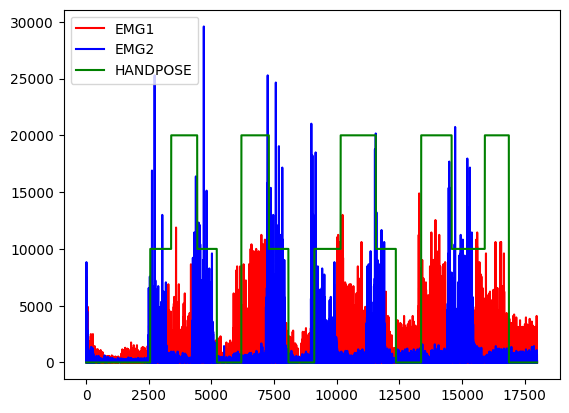

<class 'numpy.ndarray'> (17992, 3)


In [33]:
dataset = pd.read_csv(
    "/home/Hand-Gesture-Recognition-Using-ML-with-EMG-Sensors/2_EMG_Sensors_Discrete.csv"
)
plt.plot(dataset.iloc[:, 1], "r")
plt.plot(dataset.iloc[:, 0], "b")
dataset_y = list(i * 10000 for i in dataset.iloc[:, 2])
plt.plot(dataset_y, "g")
plt.legend(["EMG1", "EMG2", "HANDPOSE"], loc="upper left")
plt.show()

dataset = dataset.values.reshape(dataset.shape)
print(type(dataset), dataset.shape)

In [34]:
X, y = list(), list()
for i, _ in enumerate(dataset):
    if i + WINDOW_SIZE > len(dataset) - 1:
        break
    seq_X = dataset[i : i + WINDOW_SIZE, :-1]
    seq_y = dataset[i + WINDOW_SIZE, -1]
    # one-hot encoding
    if seq_y == 0:
        seq_y = (1, 0, 0)
    elif seq_y == 1:
        seq_y = (0, 1, 0)
    elif seq_y == 2:
        seq_y = (0, 0, 1)

    X.append(seq_X)
    y.append(seq_y)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(17492, 500, 2) (17492, 3)


In [35]:
dataset_size = len(X)
val_size = int(dataset_size * VAL_RATE)
test_size = int(dataset_size * TEST_RATE)
train_size = dataset_size - val_size - test_size

X_train, y_train = X[:train_size, :], y[:train_size, :]
X_val, y_val = (
    X[train_size : train_size + val_size, :],
    y[train_size : train_size + val_size, :],
)
X_test, y_test = (
    X[train_size + val_size :, :],
    y[train_size + val_size :, :],
)

print(
    X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
)

(10496, 500, 2) (10496, 3) (3498, 500, 2) (3498, 3) (3498, 500, 2) (3498, 3)


In [41]:
model = Sequential()
# model.add(
#     Conv2D(
#         32,
#         kernel_size=(4, 2),
#         padding="same",
#         input_shape=(1000, 8, 1),
#         kernel_regularizer=regularizers.L2(l2=L2_NORM),
#     )
# )
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(rate=DROPOUT_RATE))
# model.add(MaxPooling2D(pool_size=(5, 2)))  # output_shape = (200, 4, 1)

model.add(
    LSTM(
        50,
        input_shape=(X.shape[1], X.shape[2]),
        kernel_regularizer=regularizers.L1L2(0, L2_NORM),
    )
)
model.add(LayerNormalization())
model.add(Activation(activations.tanh))
model.add(Dropout(rate=DROPOUT_RATE))
model.add(Dense(3, activation="softmax"))

optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10600     
                                                                 
 layer_normalization_4 (Lay  (None, 50)                100       
 erNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 50)                0         
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10853 (42.39 KB)
Trainable params: 10853 (42.39 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [42]:
history = model.fit(
    X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1
)

Epoch 1/50
328/328 [==============================] - 9s 24ms/step - loss: 0.6211 - accuracy: 0.7479 - val_loss: 0.6423 - val_accuracy: 0.8445
Epoch 2/50
328/328 [==============================] - 7s 22ms/step - loss: 0.2010 - accuracy: 0.9442 - val_loss: 0.6634 - val_accuracy: 0.7856
Epoch 3/50
328/328 [==============================] - 7s 22ms/step - loss: 0.2779 - accuracy: 0.9075 - val_loss: 0.8338 - val_accuracy: 0.7867
Epoch 4/50
328/328 [==============================] - 7s 23ms/step - loss: 0.1961 - accuracy: 0.9362 - val_loss: 1.0959 - val_accuracy: 0.7576
Epoch 5/50
328/328 [==============================] - 7s 22ms/step - loss: 0.1341 - accuracy: 0.9607 - val_loss: 0.7826 - val_accuracy: 0.8293
Epoch 6/50
328/328 [==============================] - 7s 22ms/step - loss: 0.1166 - accuracy: 0.9653 - val_loss: 0.9259 - val_accuracy: 0.8622
Epoch 7/50
328/328 [==============================] - 7s 23ms/step - loss: 0.1423 - accuracy: 0.9567 - val_loss: 0.9166 - val_accuracy: 0.8408

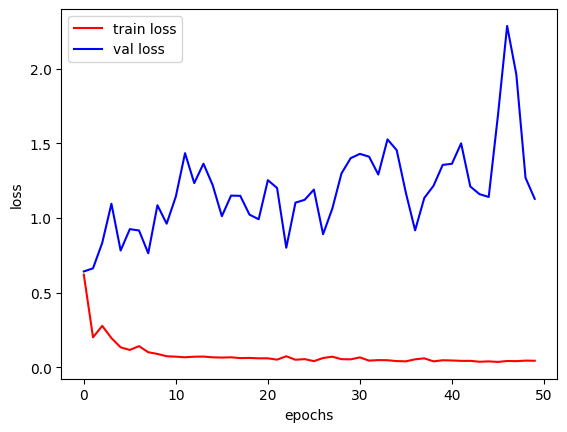

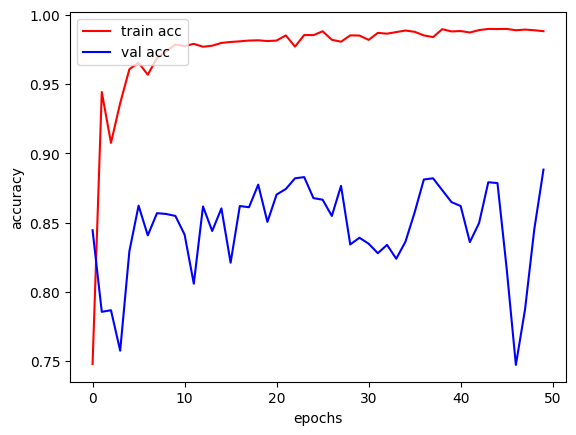

In [43]:
history.history.keys()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(history.history["loss"], "r")
plt.plot(history.history["val_loss"], "b")
plt.legend(["train loss", "val loss"], loc="upper left")
plt.show()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history.history["accuracy"], "r")
plt.plot(history.history["val_accuracy"], "b")
plt.legend(["train acc", "val acc"], loc="upper left")

110/110 [==============================] - 1s 12ms/step - loss: 2.3667 - accuracy: 0.7910
test loss, test acc: [2.3667104244232178, 0.7910234332084656]
110/110 [==============================] - 1s 9ms/step


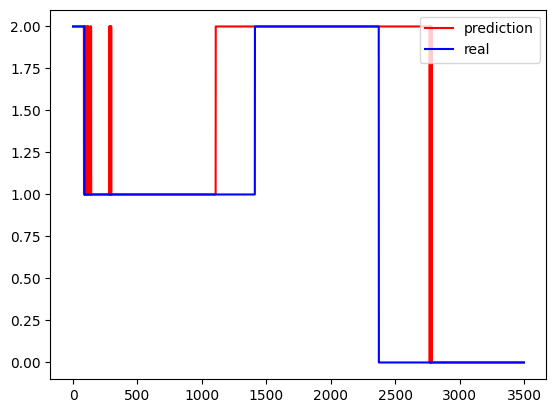

In [44]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

y_pred = model.predict(X_test)
a, b = list(), list()
for i, item in enumerate(y_pred):
    a.append(np.argmax(item))
    b.append(np.argmax(y_test[i]))

plt.plot(a, "r")
plt.plot(b, "b")
plt.legend(["prediction", "real"], loc="upper right")